In [1]:
%load_ext sql

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import peakutils
import pandas as pd
from locate import *

from scipy import signal 
%matplotlib notebook
%sql sqlite:///schema/test.db

u'Connected: None@schema/test.db'

In [19]:
cur_experiment_id = 2
result = %sql select data from mic where experiment_id = :cur_experiment_id

mic_1 = np.array(result[0][0])
mic_2 = np.array(result[1][0])
mic_3 = np.array(result[2][0])

# Median filter the data
mic_1 = median_filter(mic_1, 51)
mic_2 = median_filter(mic_2, 51)
mic_3 = median_filter(mic_3, 51)

Done.


<IPython.core.display.Javascript object>


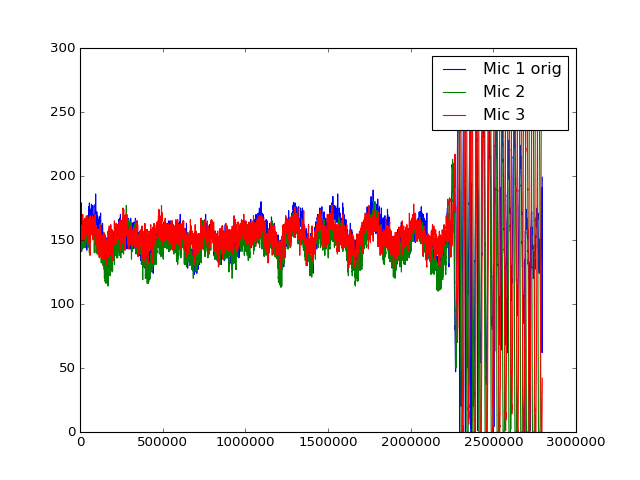

In [20]:


%matplotlib notebook
plt.figure(1)
const = 75
#plt.plot(normalize_signal(apply_butter(150, 1000, SAMPLING_FREQ, mic_1)), label='Mic 1', lw=1)#
#plt.plot(normalize_signal(apply_butter(262-const, 262+const, SAMPLING_FREQ, mic_2)), label='Mic 2', lw=1)
#plt.plot(normalize_signal(apply_butter(262-const, 262+const, SAMPLING_FREQ, mic_3)), label='Mic 3', lw=1)

#plt.plot(normalize_signal(mic_1), label='Mic 1 orig', lw=1)
#plt.plot(normalize_signal(mic_2), label='Mic 2', lw=1)
#plt.plot(normalize_signal(mic_3), label='Mic 3', lw=1)
plt.plot(mic_1, label='Mic 1 orig', lw=1)
plt.plot(mic_2, label='Mic 2', lw=1)
plt.plot(mic_3, label='Mic 3', lw=1)
plt.legend()
plt.show()

In [7]:
sig_butter = normalize_signal(apply_butter(FREQ_1, FREQ_2, SAMPLING_FREQ, mic_1))
peakutils.peak.indexes(sig_butter, thres=0.6, min_dist=1000)

array([2217364, 2252265, 2287496, 2323803, 2362263, 2402747, 2440794,
       2480884, 2519859, 2556970, 2592635, 2629422, 2665518, 2726338])

<IPython.core.display.Javascript object>


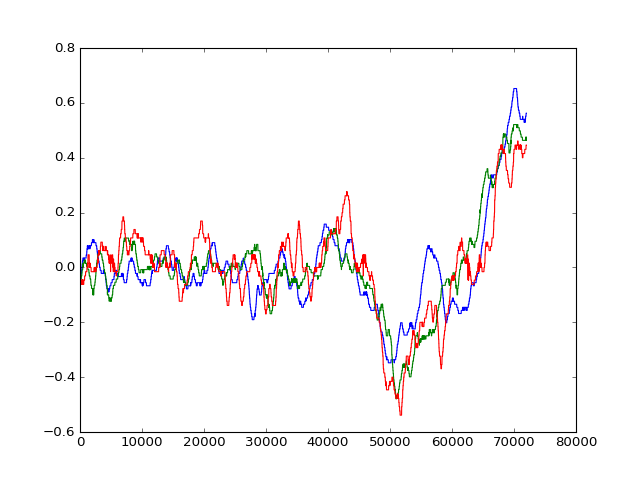

In [8]:
import locate
reload(locate)


(sigs_cropped, sigs_butter_cropped, offsets) = locate.crop_sigs(np.array([mic_1, mic_2, mic_3]))

%matplotlib notebook
plt.figure(1)
const = 75
#plt.plot(normalize_signal(sigs_butter_cropped[0]), label='Mic 1 orig', lw=1)
#plt.plot(normalize_signal(sigs_butter_cropped[1]), label='Mic 2', lw=1)
#plt.plot(normalize_signal(sigs_butter_cropped[2]), label='Mic 3', lw=1)

plt.plot(normalize_signal(sigs_cropped[0]), label='Mic 1 orig', lw=1)
plt.plot(normalize_signal(sigs_cropped[1]), label='Mic 2', lw=1)
plt.plot(normalize_signal(sigs_cropped[2]), label='Mic 3', lw=1)
#plt.legend()
plt.show()